In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from sklearn import preprocessing, linear_model

%matplotlib inline

In [2]:
data = pd.read_excel("NRCWE Instillation data for David.xlsx")
data.head()

MOUSE ID Unnamed: 1      NM NAME NM ID CODE Chemical composition  \
0   Data samlet 1        NaN          NaN        NaN                  NaN   
1             NaN        NaN          NaN        NaN                  NaN   
2  ATS 2011-01a-1        NaN  NaBond TiO2  NRCWE-025                  NaN   
3  ATS 2011-01a-2        NaN  NaBond TiO2  NRCWE-025                  NaN   
4  ATS 2011-01a-3        NaN  NaBond TiO2  NRCWE-025                  NaN   

          Route      Dispersant Dose (µg/animal) Sacrifice day    # Total  \
0           NaN             NaN              NaN           NaN        NaN   
1           NaN             NaN              NaN           NaN  BAL CELLS   
2  Instillation  2% Mouse Serum               18             1     216000   
3  Instillation  2% Mouse Serum               18             1     234000   
4  Instillation  2% Mouse Serum               18             1     222000   

   ... Primary size (nm) TEM size ECD (nm)  TEM geodesic length (nm)  \
0  ...               NaN               NaN                       NaN   
1  ...               NaN               NaN                       NaN   
2  ...                38               NaN                       NaN   
3  ...                38               NaN                       NaN   
4  ...                38               NaN                       NaN   

  BET (cm2) DLS Z-Size (nm)  DLS I-Size     PDI Purity  Impurities wt%  \
0       NaN             NaN          NaN    NaN    NaN             NaN   
1       NaN             NaN          NaN    NaN    NaN             NaN   
2      28.2         219 ± 5          NaN  0.152     99              <1   
3      28.2         219 ± 5          NaN  0.152     99              <1   
4      28.2         219 ± 5          NaN  0.152     99              <1   

  Impurities 0-1 wt%  
0                NaN  
1                NaN  
2                NaN  
3                NaN  
4                NaN  

[5 rows x 49 columns]

In [3]:
control = data[data["NM ID CODE"].isin(["Control"])]["PMN%"].dropna()

mean = 0.038686725663716795, sd = 0.056813334319817554


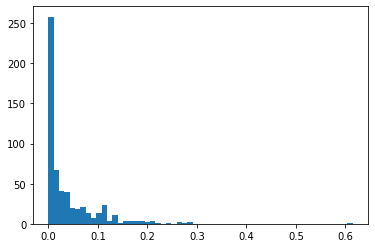

In [4]:
Y, X, p = plt.hist(control, bins = 'auto')

X = np.asarray(X[:-1], dtype = float)

controlMean = np.mean(control)

print(f"mean = {controlMean}, sd = {np.std(control)}")

<h1>Reflected Distribution</h1>

In [5]:
def rp(X, A, X0, sigma):
    return 2.0 * A * np.exp(-(np.power(X, 2.0) + np.power(X0, 2)) / (np.power(sigma, 2.0))) * np.cosh(2.0*X*X0 / np.power(sigma, 2.0)) / sigma

def e(X, A, a):
    return A * np.exp(-a * X)

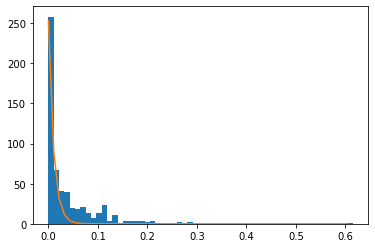

In [6]:
Y, X, p = plt.hist(control, bins = 'auto')
X = np.asarray(X[:-1], dtype = float)

#popt, pcov = curve_fit(rp, X, Y, bounds=(0, [250, 0.1, 10]))
#y2 = rp(X, popt[0], popt[1], popt[2])

popt, pcov = curve_fit(e, X, Y)
y2 = e(X, popt[0], popt[1])

plt.plot(X, y2)



In [7]:
materials = [ "NM-400", "NM-401", "NM-402", "NM-403", "NRCWE-006", "NRCWE-007", "NRCWE-026", "NRCWE-040",
    "NRCWE-041", "NRCWE-042", "NRCWE-043", "NRCWE-044", "NRCWE-045", "NRCWE-046", "NRCWE-047", "NRCWE-048",
    "NRCWE-049", "NRCWE-051", "NRCWE-052", "NRCWE-053", "NRCWE-054", "NRCWE-055", "NRCWE-056", "NRCWE-057",
    "NRCWE-061", "NRCWE-062", "NRCWE-063", "NRCWE-064", "NRCWE-001", "NRCWE-002", "NRCWE-003", "NRCWE-025",
    "NRCWE-030", "L-181", "NM-101", "PC-105", "NM-103", "NM-104", "NM-100", "NM-200", "NM-203" ]


data[data["NM ID CODE"].isin(materials)][["NM ID CODE", "Dose (µg/animal)", "PMN%"]].dropna()

NM ID CODE Dose (µg/animal)   PMN%
2     NRCWE-025               18  0.065
3     NRCWE-025               18  0.075
4     NRCWE-025               18   0.09
5     NRCWE-025               18  0.075
6     NRCWE-025               18   0.09
...         ...              ...    ...
3171     NM-401               54   0.09
3172     NM-401               54  0.015
3173     NM-401               54  0.065
3174     NM-401               54   0.06
3175     NM-401               54  0.065

[1506 rows x 3 columns]

In [8]:
for material in materials:
    subset = data[data["NM ID CODE"].isin([material])][["Dose (µg/animal)", "PMN%"]].dropna()
    doses = set(subset["Dose (µg/animal)"].values)
    
    for dose in doses:
        mean = np.mean(subset[subset["Dose (µg/animal)"].isin([dose])]["PMN%"])
        std  = np.std(subset[subset["Dose (µg/animal)"].isin([dose])]["PMN%"])
        #print(", ".join([material, str(dose), str(mean), str(std)]))
    


In [9]:
def adjusted_r2(X, Y):
    model = linear_model.LinearRegression()
    model.fit(X, Y) 
    return 1.0 - (1.0 - model.score(X, Y)) * (len(Y) - 1.0) / (len(Y) - X.shape[1] - 1.0)
    
    
# Create a boolean mask N elements long where all
# elements are false except at index n
def create_mask_all_false_bar_one(N, n):
    mask = np.zeros(N, dtype = bool)
    mask[n] = True
    return mask


def create_mask_all_true_bar_one(N, n):
    mask = np.ones(N, dtype = bool)
    mask[n] = False
    return mask
    

# Return a list of column names that give an optimal 
# adjusted correlation coefficent
def optimal_predictors(X, Y, minOptimizationStepSize = 0.01):  
    bestCorrelation = 0.0
    N               = X.shape[1]
    optimalMask     = np.zeros((N), dtype = bool) 
    done            = False
    
    while not done:
        # Forward Regression
        while True:
            masks = [ mask for mask in [ create_mask_all_false_bar_one(N, n) for n in np.arange(N) ] ]
            res   = [ adjusted_r2(X[X.columns[np.bitwise_or(optimalMask, mask) ] ], Y) for mask in masks ]
            bestIndex   = np.argmax(res)
            correlation = res[bestIndex]
            print("Forward:", bestIndex, correlation)
            if (correlation <= bestCorrelation + minOptimizationStepSize):
                break
            bestCorrelation = correlation
            optimalMask     = np.bitwise_or(optimalMask, masks[bestIndex])

        # Backwards Regression
        while True:
            masks = [ mask for mask in [create_mask_all_true_bar_one(N, n) for n in np.arange(N) ] ]
            res   = [ adjusted_r2(X[X.columns[np.bitwise_and(optimalMask, mask) ] ], Y) for mask in masks ]
            bestIndex = np.argmax(res)
            correlation = res[bestIndex]
            print("Backwards:", bestIndex, correlation)
            if (correlation <= bestCorrelation + minOptimizationStepSize):
                done = True
                break
            bestCorrelation = correlation
            optimalMask     = np.bitwise_and(optimalMask, masks[bestIndex])
        
    return X.columns[optimalMask]

In [10]:
from sklearn.model_selection import train_test_split

def CalculateR2(Ye, Yp):
    #SS_res = np.sum(np.power(Ye - Yp, 2.0))
    #SS_tot = np.sum(np.power(Ye - np.mean(Ye), 2.0))
    #return 1.0 - SS_res / SS_tot
    
    n = len(Ye)
    r = (n * np.sum(Ye * Yp) - np.sum(Ye) * np.sum(Yp)) / np.sqrt((n * np.sum(Ye * Ye) - np.sum(Ye)**2.0) * (n * np.sum(Yp * Yp) - np.sum(Yp)**2.0))
    return r * r
    

def R2_Leave_One_Out(X1, Y1):
    size = X1.shape[0]
    prediction = np.zeros((size))
    for index in range(size):
        mask = np.zeros((size), dtype = bool)
        mask[index] = True;
        linear = linear_model.LinearRegression()
        linear.fit(X1[~mask].reshape(-1, 1), Y1[~mask].reshape(-1, 1))
        prediction[index] = linear.predict(X1[mask][0].reshape(-1, 1))
    return CalculateR2(Y1.flatten(), prediction)


def R2_Leave_Many_Out(X2, Y2, test_size = 0.25):
    y2          = np.array(())
    prediction = np.array(())
    for i in range(4):
        X_train, X_test, Y_train, Y_test = train_test_split(X2, Y2, test_size = test_size)
        linear = linear_model.LinearRegression()
        linear.fit(X_train.reshape(-1, 1), Y_train.reshape(-1, 1))
        y2 = np.append(y2, Y_test)
        prediction = np.append(prediction, linear.predict(X_test.reshape(-1, 1)))
    return CalculateR2(y2, prediction)


def R2_Y_Randomize(X3, Y3):
    Y4 = np.copy(Y3)
    np.random.shuffle(Y4)
    return CalculateR2(X3, Y4)


def getR2Row(x, y, label):
    r2 = CalculateR2(x, y)
    r2_loo = R2_Leave_One_Out(x, y)
    r2_lmo = R2_Leave_Many_Out(x, y)
    r2_y_rand = R2_Y_Randomize(x, y)
    print(f"{label} & {r2:.2} & {r2_loo:.2} & {r2_lmo:.2} & {r2_y_rand:.2} \\\\")

In [11]:
data = pd.read_excel("materials_list_v0.5.xlsx", sheet_name = "PredictorsCrossInhalationReduced", index_col = 'Material')

In [48]:
#material = 'TiO2'
material = 'C'

YO = data[data['Material.1'].isin([material])]['pncells']
XO = data[data['Material.1'].isin([material])].drop(columns = ['pncells', 'stddev', 'Material.1', 'Shape'])
c = data[data['Material.1'].isin([material])]['Dose'].values

print(XO)
print(YO)

           Length  Radius  Dose      SER      PRO      ILE      ASP      ASN  \
Material                                                                       
NM-400      11.00    5.50    32 -0.22754 -4.25595 -1.97643 -0.10174 -1.91730   
NM-400      11.00    5.50   128 -0.22754 -4.25595 -1.97643 -0.10174 -1.91730   
NM-400      11.00    5.50    54 -0.22754 -4.25595 -1.97643 -0.10174 -1.91730   
NM-401      67.00   33.50   162 -0.26520 -4.53279 -2.16562 -0.11818 -2.09655   
NM-401      67.00   33.50    18 -0.26520 -4.53279 -2.16562 -0.11818 -2.09655   
...           ...     ...   ...      ...      ...      ...      ...      ...   
NRCWE-063   14.18    7.09    18 -0.27804 -3.99803 -1.60035 -0.60670 -1.57860   
NRCWE-063   14.18    7.09     6 -0.27804 -3.99803 -1.60035 -0.60670 -1.57860   
NRCWE-064    7.46    3.73    54 -0.17339 -3.26858 -1.72153 -0.49230 -1.29996   
NRCWE-064    7.46    3.73    18 -0.17339 -3.26858 -1.72153 -0.49230 -1.29996   
NRCWE-064    7.46    3.73     6 -0.17339

In [49]:
#Define and train scalers for the x and y data. Using separate objects means we can apply a back-transformation later to get real y values
#we employ the notation that XO,YO are original data, X,Y are scaled original data, y is scaled predicted data, yo is unscaled predicted data
xscaler = preprocessing.StandardScaler()
yscaler = preprocessing.StandardScaler()
X = pd.DataFrame(data = xscaler.fit_transform(XO), index = XO.index.values, columns = XO.columns.values)
# Optional
#dose = data['Dose'].values
#Y = Y / dose
Y = pd.DataFrame(yscaler.fit_transform(YO.values.reshape(-1, 1)), index = YO.index.values, columns = ["Result"])
Y = Y.values.flatten()

In [50]:
corr_matrix = X.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.90)]
X = X.drop(X[to_drop], axis=1)
print(X)

             Length      Dose       SER       PRO       ILE       ASP  \
NM-400    -0.725841 -0.036407  0.037128 -0.432620 -0.376467  0.918286   
NM-400    -0.725841  2.918160  0.037128 -0.432620 -0.376467  0.918286   
NM-400    -0.725841  0.640682  0.037128 -0.432620 -0.376467  0.918286   
NM-401     3.515074  3.964569 -0.535238 -0.859445 -0.813494  0.849694   
NM-401     3.515074 -0.467281 -0.535238 -0.859445 -0.813494  0.849694   
...             ...       ...       ...       ...       ...       ...   
NRCWE-063 -0.485018 -0.467281 -0.730383 -0.034965  0.492274 -1.188550   
NRCWE-063 -0.485018 -0.836602 -0.730383 -0.034965  0.492274 -1.188550   
NRCWE-064 -0.993928  0.640682  0.860113  1.089683  0.212350 -0.711241   
NRCWE-064 -0.993928 -0.467281  0.860113  1.089683  0.212350 -0.711241   
NRCWE-064 -0.993928 -0.836602  0.860113  1.089683  0.212350 -0.711241   

                GLU       THR      1c1z      4j1y  ...    P25685    Q15468  \
NM-400     0.427797  0.123839  0.419811  0.56

In [52]:
names = optimal_predictors(X, Y)
x = X[names]

Forward: 1 0.3521455565982744
Forward: 48 0.44069984955519514
Forward: 45 0.531938661852742
Forward: 6 0.5440863985629443
Forward: 44 0.5649313301738723
Forward: 53 0.591936432443354
Forward: 28 0.6191032434010352
Forward: 54 0.6350625452881822
Forward: 33 0.6396113232433133
Backwards: 0 0.6350625452881822


[ 0.94779422  0.91159151 -0.4385534   2.66250186 -0.18696721  0.04044903
  0.57276233  1.44514203  0.6799143   3.0858626   3.6674658   0.73790892
  1.30227944  0.01380465 -1.14581162 -0.18793379  2.5577704   1.24936625
  1.52000782 -0.63076414 -0.40375663 -1.25570399 -0.31096523 -0.96050499
 -1.14940176  0.06517131 -0.28693889 -1.04960003  0.113224   -0.17012115
 -1.30923749 -0.40375663 -0.91576628 -1.31726751 -0.29008717 -0.74675339
 -1.34671093  0.27254351  0.66251591 -1.08477918  0.41148205  0.39905463
 -0.61502275  0.78430462  0.14056432 -0.98535983  0.42004316  0.89863687
 -0.62496468  0.21098636  0.45870624  0.11073852  0.34023152  0.07594174
 -1.12206144  0.28389388 -0.45843727 -1.07235176  0.37834227  0.30709173
 -0.85114371  0.13927187 -0.21485986 -1.03506951 -0.14195234 -0.51311791
 -0.96149919  0.32531861 -0.48080662 -1.0052437   0.83732827  0.90857881
 -0.93018209  0.57552398  0.28720786 -1.03755499  0.13683609 -0.64981952
 -1.23142272  0.18447453 -0.47583566 -1.12454692]
P

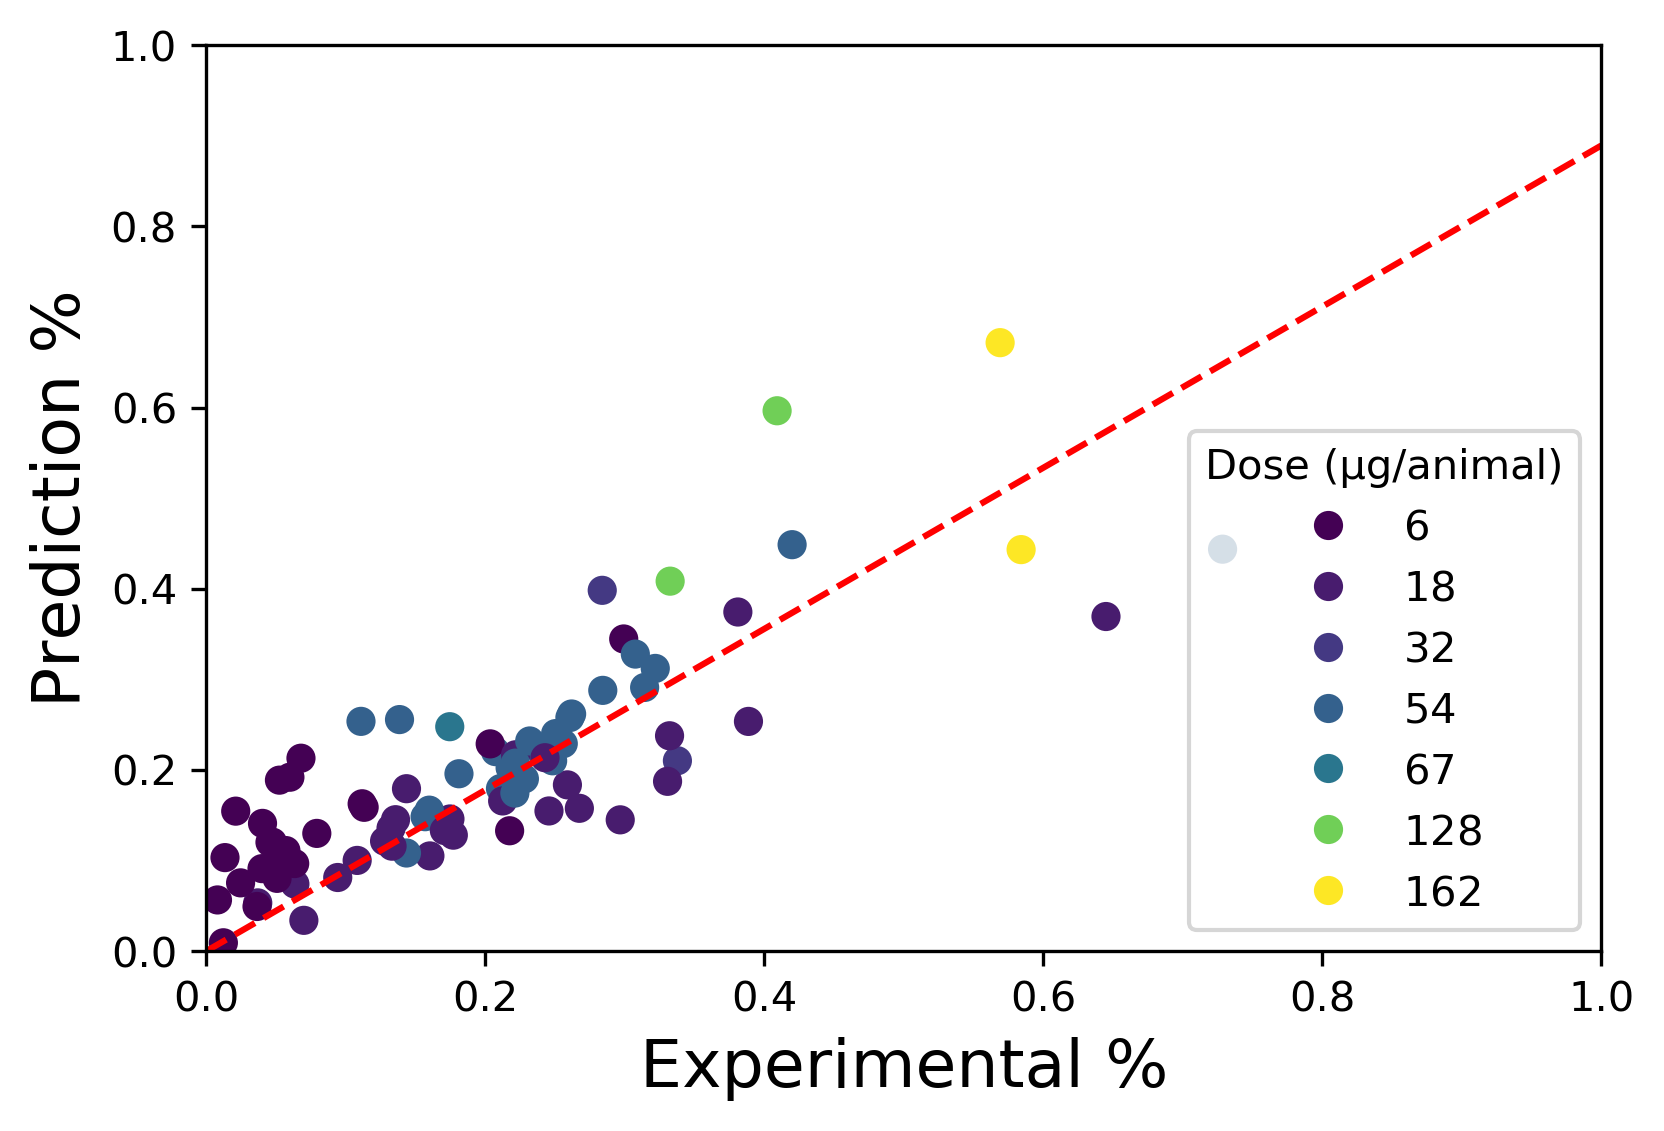

In [58]:
fontsize = 16
titlesize = 20
ticksize = 16

plt.figure(dpi = 300)


print(Y)
model = linear_model.LinearRegression()
model.fit(x, Y)

print("Predictors: " + ", ".join(names))
print(model.coef_)


y = model.predict(x)
yo = yscaler.inverse_transform(y)
scatterplot = plt.scatter(YO, yo, c = c,label=c)

legend1 = plt.legend(*scatterplot.legend_elements(),
                    loc="lower right", title="Dose (µg/animal)")

plt.xlim(0,1)
plt.ylim(0,1)


#optional
#mask = np.bitwise_and(Y > 0.5, y < 0.4)
#y = y[~mask]#
#Y = Y[~mask]

#plt.title("Inhalation", fontsize = titlesize)
plt.xlabel("Experimental %", fontsize = fontsize)
plt.ylabel("Prediction %", fontsize = fontsize)

fit_model = linear_model.LinearRegression(fit_intercept = False)
try:
    fit_model.fit(YO.values.reshape(-1, 1), yo.reshape(-1, 1))
except:
    fit_model.fit(YO.reshape(-1, 1), yo.reshape(-1, 1))
lx = np.linspace(0,1, 1000)
ly = fit_model.predict(lx.reshape(-1, 1))
plt.plot(lx, ly, '--r')

print(f"Exp-to-prediction slope: {fit_model.coef_[0]}")
try:
    getR2Row(Y.values, y, "Inhalation")
except:    
    getR2Row(Y, y, "Inhalation")

In [55]:
data.head()

Material.1 Shape   pncells  Length  Radius  Dose    stddev      SER  \
Material                                                                       
NM-400            C  Tube  0.337778    11.0     5.5    32  0.220123 -0.22754   
NM-400            C  Tube  0.332576    11.0     5.5   128  0.137874 -0.22754   
NM-400            C  Tube  0.138571    11.0     5.5    54  0.023409 -0.22754   
NM-401            C  Tube  0.584167    67.0    33.5   162  0.200078 -0.26520   
NM-401            C  Tube  0.174722    67.0    33.5    18  0.110961 -0.26520   

              PRO      ILE  ...     P04406     P01596     P02775     Q15617  \
Material                    ...                                               
NM-400   -4.25595 -1.97643  ... -55.479578 -35.895376 -39.899590 -42.958668   
NM-400   -4.25595 -1.97643  ... -55.479578 -35.895376 -39.899590 -42.958668   
NM-400   -4.25595 -1.97643  ... -55.479578 -35.895376 -39.899590 -42.958668   
NM-401   -4.53279 -2.16562  ... -58.764474 -38.465452 -42.899094 -45.287830   
NM-401   -4.53279 -2.16562  ... -58.764474 -38.465452 -42.899094 -45.287830   

             P68366     Q13310     P05067     P01611     P43652     Q6IQ26  
Material                                                                    
NM-400   -59.392105 -51.708555 -44.575391 -33.698870 -43.560439 -47.726135  
NM-400   -59.392105 -51.708555 -44.575391 -33.698870 -43.560439 -47.726135  
NM-400   -59.392105 -51.708555 -44.575391 -33.698870 -43.560439 -47.726135  
NM-401   -70.197698 -50.728610 -52.956720 -38.050128 -52.762804 -59.899429  
NM-401   -70.197698 -50.728610 -52.956720 -38.050128 -52.762804 -59.899429  

[5 rows x 619 columns]

In [19]:
when cutoff = 0.01 -> Predictors: Dose, GLU, P01614, O75915, O95445, P14923, Q2VWP7, P04406

SyntaxError: invalid syntax (<ipython-input-19-72f50b90f299>, line 1)